<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train DeepLab V3

## Clone the repository for necessary helper functions

In [0]:
import os

!git clone https://github.com/sthalles/deeplab_v3.git
os.listdir('/content/deeplab_v3')
os.chdir('deeplab_v3')

Cloning into 'deeplab_v3'...
remote: Enumerating objects: 267, done.
remote: Total 267 (delta 0), reused 0 (delta 0), pack-reused 267
Receiving objects: 100% (267/267), 571.29 KiB | 10.78 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [0]:
# Import necessary libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
slim = tf.contrib.slim
import os
import sys
import json
import network
from preprocessing.read_data import download_resnet_checkpoint_if_necessary, tf_record_parser, \
    rescale_image_and_annotation_by_factor, scale_image_with_crop_padding, \
    random_flip_image_and_annotation, distort_randomly_image_color
from preprocessing import training

W0619 04:50:20.745241 139633178437504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
batch_norm_epsilon = 1e-5            # batch norm epsilon for batch normalization
batch_norm_decay = 0.9997            # batch norm decay for batch normalization
number_of_classes = 21               # number of classes to predict 
l2_regularizer = 0.0001              # l2 regularization parameter
multi_grid = [1,2,4]                 # Spatial Pyramid Pooling rates
output_stride = 16                   # Output Stride
crop_size = 513                      # Image size to feed in the network
resnet_model = 'resnet_v2_50'        # Resnet Model [choices: "resnet_v2_50", "resnet_v2_101", "resnet_v2_152", "resnet_v2_200"]
batch_size = 8                       # Batch size 
img_shape = (513,513,3)

num_train_examples = 8498
num_valid_examples = 2857

classes = ["background","aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "potted plant", "sheep", "sofa", "train", "tv monitor", "Unknown"]

In [0]:
os.listdir('/content/tfrecords')

['train.tfrecords', 'validation.tfrecords']

# Prepare data pipeline from tf record

In [0]:
LOG_FOLDER = '/content/checkpoints'
TRAIN_DATASET_DIR="/content/tfrecords"
TRAIN_FILE = 'train.tfrecords'
VALIDATION_FILE = 'validation.tfrecords'

# Train Dataset
training_filenames = [os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE)]
training_dataset = tf.data.TFRecordDataset(training_filenames)
training_dataset = training_dataset.map(tf_record_parser)
training_dataset = training_dataset.map(rescale_image_and_annotation_by_factor)
training_dataset = training_dataset.map(distort_randomly_image_color)
training_dataset = training_dataset.map(lambda image, annotation, image_shape: scale_image_with_crop_padding(image, annotation, image_shape, crop_size))
training_dataset = training_dataset.map(random_flip_image_and_annotation)  # Parse the record into tensors.
training_dataset = training_dataset.repeat()  # number of epochs
training_dataset = training_dataset.shuffle(buffer_size=500)
training_dataset = training_dataset.batch(batch_size)

# Validation Dataset
validation_filenames = [os.path.join(TRAIN_DATASET_DIR,VALIDATION_FILE)]
validation_dataset = tf.data.TFRecordDataset(validation_filenames)
validation_dataset = validation_dataset.map(tf_record_parser)  # Parse the record into tensors.
validation_dataset = validation_dataset.map(lambda image, annotation, image_shape: scale_image_with_crop_padding(image, annotation, image_shape, crop_size))
validation_dataset = validation_dataset.shuffle(buffer_size=100)
validation_dataset = validation_dataset.batch(batch_size)

# A feedable iterator is defined by a handle placeholder and its structure.
handle = tf.placeholder(tf.string, shape=[])

iterator = tf.data.Iterator.from_string_handle(handle, training_dataset.output_types, training_dataset.output_shapes)
batch_images_tf, batch_labels_tf, _ = iterator.get_next()

# You can use feedable iterators with a variety of different kinds of iterator
# (such as one-shot and initializable iterators).
train_iterator = training_dataset.make_initializable_iterator()
valid_iterator = validation_dataset.make_initializable_iterator()

W0619 04:50:20.906049 139633178437504 deprecation_wrapper.py:119] From /content/deeplab_v3/preprocessing/read_data.py:115: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.

W0619 04:50:20.907540 139633178437504 deprecation_wrapper.py:119] From /content/deeplab_v3/preprocessing/read_data.py:121: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W0619 04:50:20.938275 139633178437504 deprecation.py:323] From /content/deeplab_v3/preprocessing/read_data.py:132: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0619 04:50:20.940353 139633178437504 deprecation.py:323] From /content/deeplab_v3/preprocessing/read_data.py:134: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0619 04:50:20.967399 139633178437504 

# Create a temporary dataset for visualisation

In [0]:
# Temporary Dataset
validation_filenames = [os.path.join(TRAIN_DATASET_DIR,VALIDATION_FILE)]
temp_dataset = tf.data.TFRecordDataset(validation_filenames)
temp_dataset = temp_dataset.map(tf_record_parser)
temp_dataset = temp_dataset.map(lambda image, annotation, image_shape: scale_image_with_crop_padding(image, annotation, image_shape, crop_size)) 
temp_dataset = temp_dataset.shuffle(buffer_size=500)
temp_dataset = temp_dataset.batch(8)

temp_iterator = temp_dataset.make_one_shot_iterator()
temp_images_tf, temp_labels_tf, _ = temp_iterator.get_next()

W0619 04:50:23.505025 139633178437504 deprecation.py:323] From <ipython-input-6-431d020cd9c4>:8: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


# Visualise Train Augmentation 

Image Shape: (8, 513, 513, 3)
Annotation Shape: (8, 513, 513)


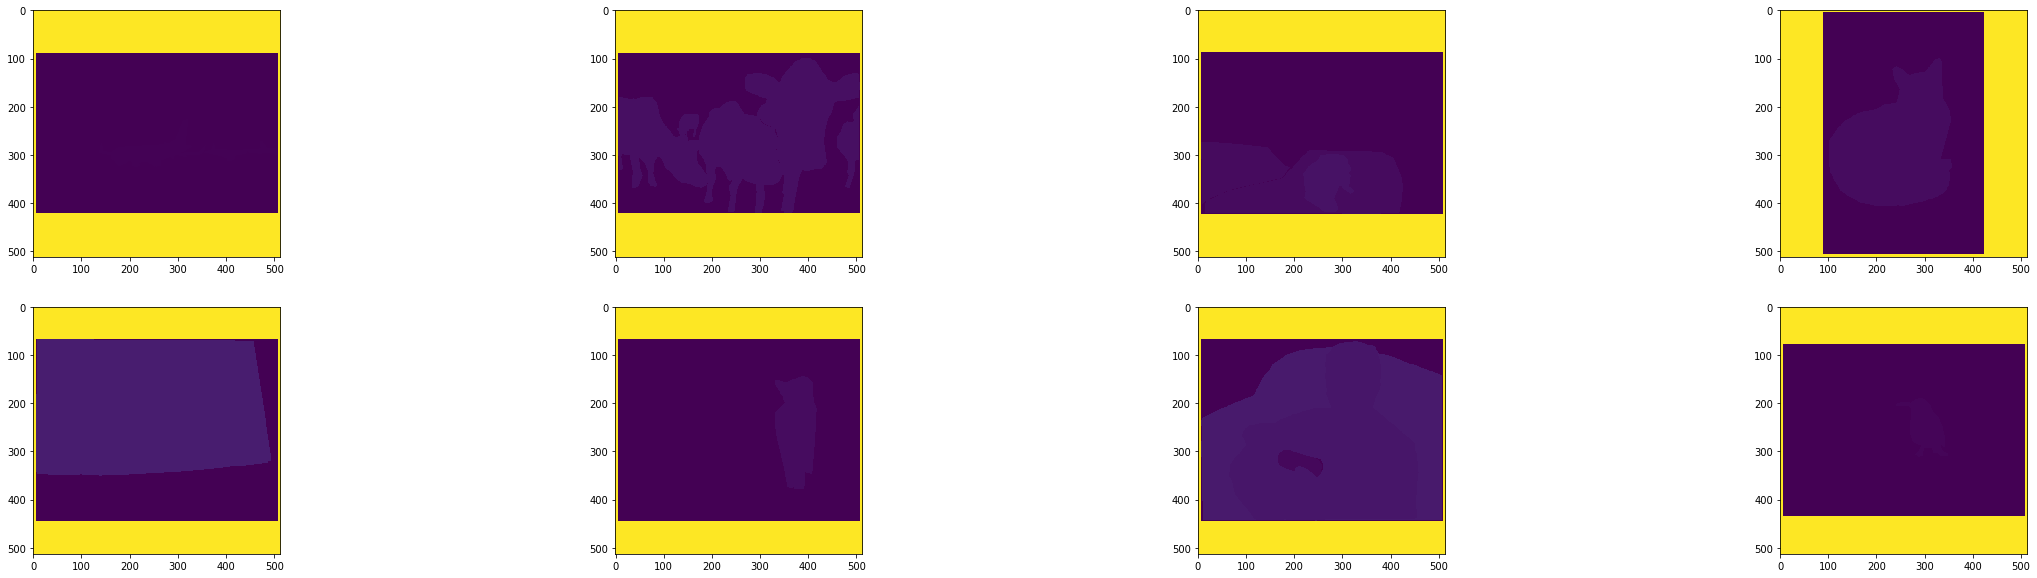

In [0]:
with tf.Session() as sess:
    
    image, annotation = sess.run([temp_images_tf,temp_labels_tf])
    
    print('Image Shape: {}'.format(np.shape(image)))
    print('Annotation Shape: {}'.format(np.shape(annotation)))

    plt.figure(figsize = (40,10))
    
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(annotation[i])
    

# Define the model

In [0]:
import tensorflow as tf
slim = tf.contrib.slim
from resnet import resnet_v2, resnet_utils

# ImageNet mean statistics
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

@slim.add_arg_scope
def atrous_spatial_pyramid_pooling(net, scope, depth=256, reuse=None):
    """
    ASPP consists of (a) one 1×1 convolution and three 3×3 convolutions with rates = (6, 12, 18) when output stride = 16
    (all with 256 filters and batch normalization), and (b) the image-level features as described in https://arxiv.org/abs/1706.05587
    :param net: tensor of shape [BATCH_SIZE, WIDTH, HEIGHT, DEPTH]
    :param scope: scope name of the aspp layer
    :return: network layer with aspp applyed to it.
    """

    with tf.variable_scope(scope, reuse=reuse):
        feature_map_size = tf.shape(net)

        # apply global average pooling
        image_level_features = tf.reduce_mean(net, [1, 2], name='image_level_global_pool', keepdims=True)
        
        image_level_features = slim.conv2d(image_level_features, depth, [1, 1], scope="image_level_conv_1x1", activation_fn=None)
        
        image_level_features = tf.image.resize_bilinear(image_level_features, (feature_map_size[1], feature_map_size[2]))

        at_pool1x1 = slim.conv2d(net, depth, [1, 1], scope="conv_1x1_0", activation_fn=None)

        at_pool3x3_1 = slim.conv2d(net, depth, [3, 3], scope="conv_3x3_1", rate=6, activation_fn=None)

        at_pool3x3_2 = slim.conv2d(net, depth, [3, 3], scope="conv_3x3_2", rate=12, activation_fn=None)

        at_pool3x3_3 = slim.conv2d(net, depth, [3, 3], scope="conv_3x3_3", rate=18, activation_fn=None)

        net = tf.concat((image_level_features, at_pool1x1, at_pool3x3_1, at_pool3x3_2, at_pool3x3_3), axis=3, name="concat")
        
        net = slim.conv2d(net, depth, [1, 1], scope="conv_1x1_output", activation_fn=None)
        
        return net


def deeplab_v3(inputs, l2_regularizer, batch_norm_decay, batch_norm_epsilon, resnet_model, number_of_classes, output_stride, is_training, reuse):

    # mean subtraction normalization
    inputs = inputs - [_R_MEAN, _G_MEAN, _B_MEAN]

    # inputs has shape - Original: [batch_size, 513, 513, 3]
    with slim.arg_scope(resnet_utils.resnet_arg_scope(l2_regularizer, is_training, batch_norm_decay, batch_norm_epsilon)):
        
        resnet = getattr(resnet_v2, resnet_model)
        
        _, end_points = resnet(inputs, 
                               number_of_classes,
                               is_training=is_training,
                               global_pool=False,
                               spatial_squeeze=False,
                               output_stride=output_stride,
                               reuse=reuse)

        with tf.variable_scope("DeepLab_v3", reuse = reuse):

            # get block 4 feature outputs
            net = end_points[resnet_model + '/block4']

            net = atrous_spatial_pyramid_pooling(net, scope = "ASPP_layer", depth=256, reuse=reuse)

            net = slim.conv2d(net, number_of_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='logits')

            size = tf.shape(inputs)[1:3]
            # resize the output logits to match the labels dimensions
            net = tf.image.resize_bilinear(net, size)
            
            return net

# Download the checkpoint

In [0]:
resnet_checkpoints_path = "./resnet/checkpoints/"
download_resnet_checkpoint_if_necessary(resnet_checkpoints_path, resnet_model)

Resnet: resnet_v2_50 successfully downloaded.


# Define the loss and optimizer

In [0]:
# define the class labels
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

is_training_tf = tf.placeholder(tf.bool, shape=[])

logits_tf = tf.cond(is_training_tf, true_fn = lambda: deeplab_v3(batch_images_tf, l2_regularizer, batch_norm_decay, batch_norm_epsilon, resnet_model, number_of_classes, output_stride, is_training=True, reuse=False),
                                   false_fn = lambda: deeplab_v3(batch_images_tf, l2_regularizer, batch_norm_decay, batch_norm_epsilon, resnet_model, number_of_classes, output_stride, is_training=False, reuse=True))

# get valid logits and labels (factor the 255 padded mask out for cross entropy)
valid_labels_batch_tf, valid_logits_batch_tf = training.get_valid_logits_and_labels(annotation_batch_tensor=batch_labels_tf, 
                                                                                    logits_batch_tensor=logits_tf, 
                                                                                    class_labels=class_labels)

cross_entropies = tf.nn.softmax_cross_entropy_with_logits_v2(logits=valid_logits_batch_tf,
                                                             labels=valid_labels_batch_tf)

loss = tf.reduce_mean(cross_entropies)

# prediction_tensor is the argmax of logits
predictions_tf = tf.argmax(logits_tf, axis=3)

# Define the function for Mean IOU
mean_iou, update_op = tf.contrib.metrics.streaming_mean_iou(tf.argmax(valid_logits_batch_tf, axis=1),
                                                        tf.argmax(valid_labels_batch_tf, axis=1),
                                                        num_classes=number_of_classes) 


with tf.variable_scope("optimizer_vars"):
    global_step = tf.Variable(0, trainable = False)
    optimizer_1 = tf.train.AdamOptimizer(learning_rate = 0.00001).minimize(loss)
    optimizer_2 = tf.train.AdamOptimizer(learning_rate = 0.000001).minimize(loss)
    optimizer_3 = tf.train.AdamOptimizer(learning_rate = 0.0000001).minimize(loss)
    
optimizers = [optimizer_1, optimizer_2, optimizer_3]
epochs = [7,10,10]    

W0619 04:50:48.236351 139633178437504 deprecation_wrapper.py:119] From /content/deeplab_v3/resnet/resnet_v2.py:184: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0619 04:50:54.097642 139633178437504 deprecation.py:323] From /content/deeplab_v3/preprocessing/training.py:123: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0619 04:50:54.234465 139633178437504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1179: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Function to overwrite the console output

In [0]:
def print_overwrite(step, total_step, loss, mean_iou, operation):
    sys.stdout.write('\r')
    
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f  Mean IOU: %.4f" % (step, total_step, loss, mean_iou))
        
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f  Mean IOU: %.4f" % (step, total_step, loss, mean_iou))
        
    sys.stdout.flush()

## Function to train the model

In [0]:
def train():
    
    train_steps = int(np.ceil(num_train_examples / float(batch_size)))
    valid_steps = int(np.ceil(num_valid_examples / float(batch_size)))


    for i, optimizer in enumerate(optimizers):

            print('##################### Optimization: {} #####################'.format(i+1))

            for epoch in range(epochs[i]):

                loss_train = 0
                loss_valid = 0

                mean_iou_train = 0
                mean_iou_valid = 0

                running_loss = 0
                running_mean_iou = 0

                for step in range(1,train_steps):

                    # Train our model on the batch of data
                    loss_train_step, mean_iou_train_step, _, _ = sess.run([loss,mean_iou, update_op, optimizer], feed_dict = {handle: train_handle, is_training_tf: True})

                    loss_train += loss_train_step
                    mean_iou_train += mean_iou_train_step

                    running_loss = loss_train/step
                    running_mean_iou = mean_iou_train/step

                    print_overwrite(step, train_steps, running_loss, running_mean_iou, 'train')

                for step in range(1,valid_steps):

                    loss_valid_step, mean_iou_valid_step, _ = sess.run([loss,mean_iou, update_op], feed_dict = {handle: valid_handle, is_training_tf: True})

                    loss_valid += loss_valid_step
                    mean_iou_valid += mean_iou_valid_step

                    running_loss = loss_valid/step
                    running_mean_iou = mean_iou_valid/step

                    print_overwrite(step, valid_steps, running_loss, running_mean_iou, 'valid')

                loss_train /= train_steps    
                loss_valid /= valid_steps
                mean_iou_train /= train_steps
                mean_iou_valid /= valid_steps

                print('\n-----------------------------------------------------------------')
                print ("Epoch: " + str(epoch+1) + ", Train Loss: " + "{:.4f}".format(loss_train) + ", Train IOU: " + "{:.4f}".format(mean_iou_train))
                print ("          Valid Loss: " + "{:.4f}".format(loss_valid) + ", Valid IOU: " + "{:.4f}".format(mean_iou_valid))
                print('-----------------------------------------------------------------')

# Training the model

In [0]:
# Declare the variable to restore
variables_to_restore = slim.get_variables_to_restore(exclude=[resnet_model + "/logits", "optimizer_vars","DeepLab_v3/ASPP_layer", "DeepLab_v3/logits"])

# Add an operation to restore all the variables.
restorer = tf.train.Saver(variables_to_restore)

with tf.Session() as sess:

    # Create a saver.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # load resnet checkpoints
    restorer.restore(sess, "./resnet/checkpoints/" + resnet_model + ".ckpt")
    print("Model checkpoints for " + resnet_model + " restored!")

    train_handle = sess.run(train_iterator.string_handle())
    valid_handle = sess.run(valid_iterator.string_handle())

    sess.run(train_iterator.initializer)
    sess.run(valid_iterator.initializer)

    train()

    # Save the variables 
    save_path = saver.save(sess, LOG_FOLDER + "/train" + "/model.ckpt")

W0619 04:51:24.455890 139633178437504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Model checkpoints for resnet_v2_50 restored!
##################### Optimization: 1 #####################
Valid Steps: 357/358  Loss: 0.4936  Mean IOU: 0.3693
-----------------------------------------------------------------
Epoch: 1, Train Loss: 0.8976, Train IOU: 0.2485
          Valid Loss: 0.4922, Valid IOU: 0.3683
-----------------------------------------------------------------
Train Steps: 2/1063  Loss: 0.6077  Mean IOU: 0.3811